In [23]:
import matplotlib.pyplot as plt
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, LayerGroup
import pandas
from ipywidgets import widgets
from IPython.display import display, clear_output

In [2]:
def refactor_timestamp(timestamp):
    split_timestamp = timestamp.split(' ')
    if (len(split_timestamp[1]) == 1):
        return split_timestamp[0] + ' 0' + split_timestamp[1]
    else:
        return timestamp

In [3]:
data = pandas.read_csv('./2016-06.csv')
relevant_regions = pandas.read_csv('./relevant_regions.csv', header=-1, names=['0', 'region'])
regions_full = pandas.read_csv('./regions.csv', delimiter=';')
regions = regions_full[regions_full['region'].isin(relevant_regions['region'])]

In [4]:
predictions_full = pandas.read_csv('./2016_06_predictions_regression_ext.csv')

timestamp = predictions_full['id'].apply(lambda x: x[5:18].replace('_', ' ').strip()).apply(refactor_timestamp)
region = predictions_full['id'].apply(lambda x: int(x[0:4]))
prediction_number = predictions_full['id'].apply(lambda x: int(x[18:].replace('_', ' ').strip()))

predictions_full['timestamp'] = timestamp
predictions_full['region'] = region
predictions_full['prediction_number'] = prediction_number
predictions_full = predictions_full.rename(columns={'y': 'value'})

predictions = predictions_full[predictions_full['prediction_number'] == 1]

### Карты

In [5]:
def get_color_map(colors, min_value):
    result = []
    for i in range(0, len(colors)):
        color = [];
        for j in range(0,3):
            color.append(int(255 * colors[i, j]))
        if (i < min_value):
            color.append(0.0)
        else:
            color.append(1.0)
        result.append(tuple(color))
    return result

In [6]:
def get_rectangles(regions, data, color_map):
    rectangles = []
    for i in range(0, regions.shape[0]):
        region = regions.iloc[i, 0];
        west = regions.iloc[i, 1];
        east = regions.iloc[i, 2];
        south = regions.iloc[i, 3];
        north = regions.iloc[i, 4];
        
        color = color_map[int(data[data['region'] == region]['value'].sum())]
        
        rectangle = Rectangle(
            bounds=((north, east), (south, west)), 
            fill_color="#{:02x}{:02x}{:02x}".format(color[0], color[1], color[2]), 
            stroke=False, 
            fill_opacity=0.9
        )
        rectangles.append(rectangle)
    return LayerGroup(layers=rectangles)

In [7]:
def rerender(m, old_layer, new_layer):
    if (old_layer != None):
        m.remove_layer(old_layer)
    m.add_layer(new_layer)

In [8]:
def show_results(regions, data, color_map):
    global current_layer
    layer_group = get_rectangles(regions, data, color_map)
    rerender(m, current_layer, layer_group)
    current_layer = layer_group

In [9]:
def get_options(start, stop):
    days = []
    for d in range(start, stop):
        days.append(str(d))
    return days

In [10]:
def get_value_string(day):
    if len(day) == 2:
        return day
    else:
        return '0' + day

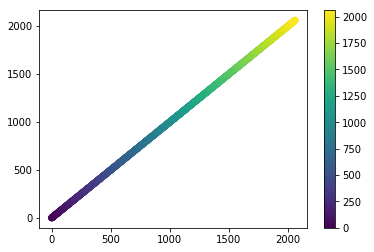

In [11]:
x = y = t = range(0, 2060 + 1)
plot = plt.scatter(x, y, c=t)
plt.colorbar()

In [12]:
color_map = get_color_map(plot.to_rgba(x), 0)

----------------------------------------------------------------------------------------------------------

In [13]:
chosen_data = data
chosen_day = '1'
chosen_hour = '0'

In [14]:
chosen_data_value = 0

dropdown_data = widgets.Dropdown(
    options={'Real': 0, 'Predictions': 1},
    value=0,
    description='Data:',
    disabled=False,
)

def handle_data_submit(data_value):
    global chosen_data
    global chosen_data_value
    if data_value.owner.value != chosen_data_value:
        if data_value.owner.value == 0:
            chosen_data = data
        else:
            chosen_data = predictions
    
        chosen_data_value = data_value.owner.value
        show_results(
            regions, 
            chosen_data[chosen_data['timestamp'] == '2016-06-' + get_value_string(chosen_day) + ' ' + get_value_string(chosen_hour)],
            color_map,
        )
        
dropdown_data.observe(handle_data_submit)

In [15]:
dropdown_day = widgets.Dropdown(
    options=get_options(1, 31),
    value='1',
    description='Day:',
    disabled=False,
)

def handle_day_submit(day):
    global chosen_day
    if day.owner.value != chosen_day:
        chosen_day = day.owner.value
        show_results(
            regions, 
            chosen_data[chosen_data['timestamp'] == '2016-06-' + get_value_string(chosen_day) + ' ' + get_value_string(chosen_hour)],
            color_map,
        )
    
dropdown_day.observe(handle_day_submit)

In [16]:
dropdown_hour = widgets.Dropdown(
    options=get_options(0, 24),
    value='0',
    description='Hour:',
    disabled=False,
)

def handle_hour_submit(hour):
    global chosen_hour
    if hour.owner.value != chosen_hour:
        chosen_hour = hour.owner.value
        show_results(
            regions, 
            chosen_data[chosen_data['timestamp'] == '2016-06-' + get_value_string(chosen_day) + ' ' + get_value_string(chosen_hour)],
            color_map,
        )
    
dropdown_hour.observe(handle_hour_submit)

In [17]:
new_york_coordinates = (40.75, -74.00)
m = Map(center=new_york_coordinates, zoom=10)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[40.75, -74.0], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']),), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'interpolation', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom', u'basemap'], zoom=10)

In [18]:
current_layer = None
show_results(regions, data[data['timestamp'] == '2016-06-03 00'], color_map)

--------------------------------------------------------------------------------------------------------------

In [19]:
print 'Выберите реальные данные или предсказания'
display(dropdown_data)

Выберите реальные данные или предсказания


Dropdown(description=u'Data:', options={'Real': 0, 'Predictions': 1}, value=0)

In [20]:
print 'Выберите день в июне 2016 года'
display(dropdown_day)

Выберите день в июне 2016 года


Dropdown(description=u'Day:', options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'), value='1')

In [21]:
print 'Выберите час'
display(dropdown_hour)

Выберите час


Dropdown(description=u'Hour:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'), value='0')

### Графики

Dropdown(description=u'Region:', index=84, options=(1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431, 1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483, 1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069, 2118, 2119, 2168), value=1442)

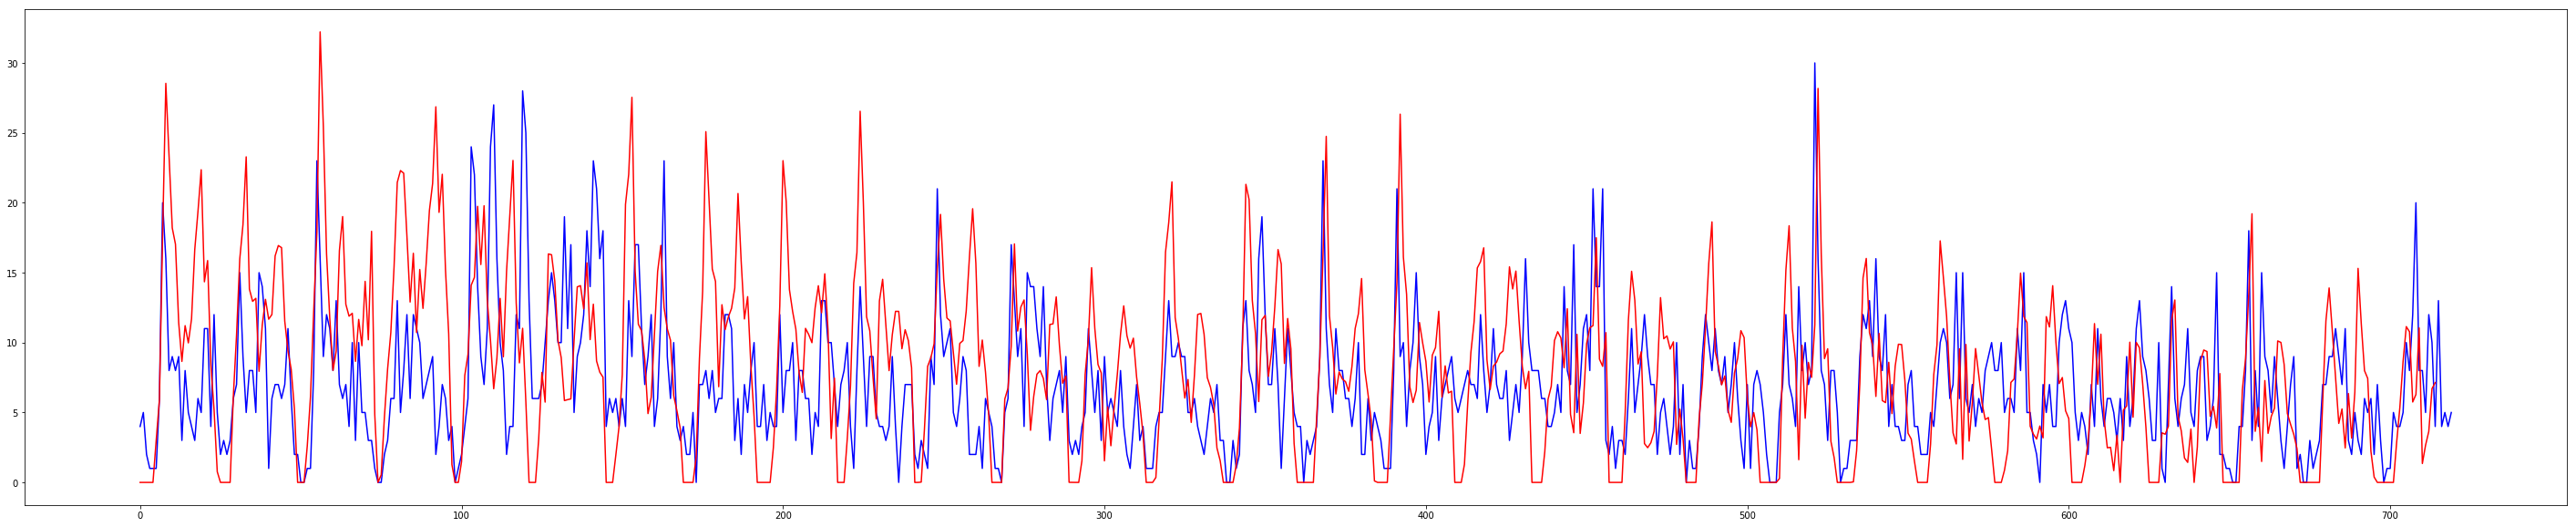

In [26]:
def plot(region):
    clear_output(wait=True)
    display(dropdown_region)
    plt.plot(range(0, 720), data[data['region'] == region]['value'], color='b', figure=plt.figure(figsize=(50,10)))
    plt.plot(range(0, 715), predictions[predictions['region'] == region]['value'], color='r')
    plt.show()
    
chosen_region = 1231

dropdown_region = widgets.Dropdown(
    options=list(relevant_regions['region']),
    value=1231,
    description='Region:',
    disabled=False,
)

def handle_region_submit(region):
    global chosen_region
    if region.owner.value != chosen_region:
        chosen_region = region.owner.value
        plot(region.owner.value)
        
dropdown_region.observe(handle_region_submit)

print 'Выберите регион'
display(dropdown_region)
plt.plot(range(0, 720), data[data['region'] == chosen_region]['value'], color='b', figure=plt.figure(figsize=(50,10)))
plt.plot(range(0, 715), predictions[predictions['region'] == chosen_region]['value'], color='r')